# D5_Mission_Diagnostics
<br>
This Jupyter Notebook is used to generate diagnostic charts by comparing the Drone Flight Log file with the Mote Data Log file.<br>
<br>The following charts are produced:<br>
* Plot Predicted Bearing to Target<br>
* Plot Range vs Prediction Error<br>
* Plot Bearing Predicton Error Distribution<br>
* Plot Mean Error and Standard Deviation by Range<br>
<br>
Chart Images are saved in the '.\images' folder


In [1]:
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
# Parameters

#select which mission to replay
#mission = 'P1D4T8F1'
#mission = 'P1D4T8F2a'
#mission = 'P1D4T8F2b' # not working
#mission = 'P1D4T8F3'
mission = 'P1D4T8F4'

mote_lon = -0.45495 
mote_lat = 51.99967

Simulation_step = 100 #ms

img_path = "./images"



In [3]:
def LoadLitchiFlightLog(filename):
    #Load the data as a pandas dataframe
    df = pd.read_csv(filename, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

    # remove the unnecessary columns from the dataframe
    header_list = list(df[:0])
    required_columns = ['timestamp', 'time(millisecond)',  'latitude', 'longitude', 'altitude(m)', 'isflying']
    for header in header_list:
        if(not(header in required_columns)):
            del df[header]

    #overwrite the datatypes of dataframe
    data_types = df.astype({
                'timestamp': 'float64',
                'time(millisecond)': 'float64',
                'latitude': 'float64',
                'longitude': 'float64',
                'altitude(m)': 'float64',
                'isflying': 'int',
                }).dtypes
    df = df.astype(data_types)

    return df

def GetDroneStatus(df, UTC):
    #print(">>>>>>>> UTC:", UTC)
    drone_status = df[df['timestamp'] <= UTC].iloc[-1]
    lat = drone_status['latitude']
    lon = drone_status['longitude']
    height = drone_status['altitude(m)']
    groundOrSky = drone_status['isflying']
    Flytime = drone_status['time(millisecond)']
    Timestamp = drone_status['timestamp']
    return Timestamp, Flytime, lat, lon, height, groundOrSky

def GetEndUTC(df):
    endUTC = df.iloc[-1]['timestamp']
    print(">>>>>>>> FLIGHT LOG END UTC:\t", endUTC)
    return endUTC 

def GetStartUTC(df):
    startUTC = df.iloc[0]['timestamp']
    print(">>>>>>>> FLIGHT LOG START UTC:\t", startUTC)
    return startUTC

def LoadCNNLog(fname):
    #Load the data as a pandas dataframe
    df = pd.read_csv(fname, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

    #overwrite the datatypes of dataframe
    data_types = df.astype({
                'UTC (ms)': 'float64',
                'CNN Confidence': 'float64',
                'CNN Bearing': 'float64',
                'Confidence (Filtered)': 'float64',
                'Bearing (Filtered)': 'float64',
                'Drone Detected': 'float64',
                }).dtypes

    df = df.astype(data_types)
    return df

def GetCNNStatus(df, UTC):
    #print(">>>>>>>> UTC:", UTC)
    drone_status = df[df['UTC (ms)'] <= UTC].iloc[-1]
    TIME = drone_status['UTC (ms)']
    BRG = drone_status['Bearing (Filtered)']
    CONF = drone_status['Confidence (Filtered)']
    ISDRONE = drone_status['Drone Detected']
    return TIME, BRG, CONF, ISDRONE

def GetCNNLogStartUTC(df):
    startUTC = df.iloc[0]['UTC (ms)']
    print(">>>>>>>> CNN LOG START UTC:\t", startUTC)
    return startUTC


def GetCNNLogEndUTC(df):
    endUTC = df.iloc[-1]['UTC (ms)']
    print(">>>>>>>> CNN LOG END UTC:\t", endUTC)
    return endUTC


    
class point(object):
    def __init__(self, lon, lat):
        
        # Datum position
        self.lon_datum = -0.45495 
        self.lat_datum = 51.99967
        
        self.lon = lon 
        self.lat = lat
        
        self.range = self.haversine(self.lon_datum, self.lat_datum, self.lon, self.lat)
        self.brng = self.bearing(self.lon_datum, self.lat_datum, self.lon, self.lat)
        
    def haversine(self, lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371000 # Radius of earth in meters. 
        return c * r    

    def bearing(self, lon1, lat1, lon2, lat2):
        #delta_lon = lon2 - lon1
        
        lon1 = math.radians(lon1)
        lat1 = math.radians(lat1)
        lon2 = math.radians(lon2)
        lat2 = math.radians(lat2)
        
        
        y = math.sin(lon2-lon1) * math.cos(lat2)
        x = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(lon2-lon1)
        theta = math.atan2(y, x)
        #brng = math.degrees(theta)
        
        
        brng = (theta*180/math.pi + 360) % 360 # in degrees
        return brng
        
    def getRange(self):
        self.range = self.haversine(self.lon_datum, self.lat_datum, self.lon, self.lat)
        return self.range
    
    def getBearing(self):
        self.brng = self.bearing(self.lon_datum, self.lat_datum, self.lon, self.lat)
        return self.brng
        
        
        
def GetAngleError(targetA, sourceA):
    a = targetA - sourceA
    a = (a + 180) % 360 - 180
    return a
        
        

# Load up Flight Log and CNN Log

In [4]:


if mission == 'P1D4T8F1':        
    FlightLogFname = './DJI_Flight_Logs/2021-08-11_17-59-07_v2.csv'
    MoteLogFname = './CNN_Logs/1628701000496_prediction_log.csv'
    mission_str = "P1D4 TRIAL 8, FLIGHT 1"
    file_str = "P1D4T8F1"

elif mission == 'P1D4T8F2a':
    FlightLogFname = './DJI_Flight_Logs/2021-08-11_18-18-09_v2.csv'
    MoteLogFname = './CNN_Logs/1628702203042_prediction_log.csv'
    mission_str = "P1D4 TRIAL 8, FLIGHT 2a"
    file_str = "P1D4T8F2a"

elif mission == 'P1D4T8F2b':
    FlightLogFname = './DJI_Flight_Logs/2021-08-11_18-28-06_v2.csv'
    MoteLogFname = './CNN_Logs/1628703640950_prediction_log.csv'
    mission_str = "P1D4 TRIAL 8, FLIGHT 2b"
    file_str = "P1D4T8F2b"

elif mission == 'P1D4T8F3':
    FlightLogFname = './DJI_Flight_Logs/2021-08-11_19-05-51_v2.csv'
    MoteLogFname = './CNN_Logs/1628705107648_prediction_log.csv'
    mission_str = "P1D4 TRIAL 8, FLIGHT 3"
    file_str = "P1D4T8F3"

elif mission == 'P1D4T8F4':
    FlightLogFname = './DJI_Flight_Logs/2021-08-11_19-42-59_v2.csv'
    MoteLogFname = './CNN_Logs/1628707327839_prediction_log.csv'
    mission_str = "P1D4 TRIAL 8, FLIGHT 4"
    file_str = "P1D4T8F4"


#Load the drone flight log & CNN Log
FlightData = LoadLitchiFlightLog(FlightLogFname) # returns a pandas dataframe
CNNData = LoadCNNLog(MoteLogFname)

#Get CNN initial conditions        
CNNDataStartUTC = GetCNNLogStartUTC(CNNData)
CNNDataEndUTC = GetCNNLogEndUTC(CNNData)

# Get drone initial conditions
FlightDataStartUTC = GetStartUTC(FlightData)
FlightDataEndUTC = GetEndUTC(FlightData)

# determine simulation start & end times
simulation_Start_UTC = min(FlightDataStartUTC, CNNDataStartUTC)
simulation_End_UTC = max(FlightDataEndUTC, CNNDataEndUTC)
simulation_length = int(simulation_End_UTC - simulation_Start_UTC)
print(">>>>>>>> SIMULATION START UTC:\t", simulation_Start_UTC)
print(">>>>>>>> SIMULATION END UTC:\t", simulation_End_UTC)
print(">>>>>>>> SIMULATION LENGTH (ms):\t", simulation_length)



>>>>>>>> CNN LOG START UTC:	 1628707328951.0
>>>>>>>> CNN LOG END UTC:	 1628708226030.0
>>>>>>>> FLIGHT LOG START UTC:	 1628707379122.0
>>>>>>>> FLIGHT LOG END UTC:	 1628708163060.0
>>>>>>>> SIMULATION START UTC:	 1628707328951.0
>>>>>>>> SIMULATION END UTC:	 1628708226030.0
>>>>>>>> SIMULATION LENGTH (ms):	 897079


# Merge Drone and CNN Log and Generate Bearing and Range to target data

In [5]:
# Initialise Drone data
Drone_TS, Drone_Flytime, Drone_lat, Drone_lon, Drone_height, Drone_groundOrSky = GetDroneStatus(df = FlightData, UTC = FlightDataStartUTC)
Drone_groundOrSky = 0.0
Drone_height = 0.0
Drone_TS = 0.0
DronePoint = point(lon = Drone_lon, lat = Drone_lat)
DronePoint.lon_datum = mote_lon 
DronePoint.lat_datum = mote_lat
DronePoint.getRange()
DronePoint.getBearing()
Drone_rng = DronePoint.getRange()
Drone_brg = DronePoint.getBearing()

# Initialise CNN  Data 
CNN_TIME, CNN_BRG, CNN_CONF, CNN_ISDRONE = GetCNNStatus(df = CNNData, UTC = CNNDataStartUTC)
PredictionError = 0.0

# Create a dataframe to contain the merged data
columns = ['Timestamp (ms)',
           'Drone Timestamp (ms)', 
           'Drone Flytime',
           'Drone Latitude',
           'Drone Longitude',
           'Drone Altitude (m)',
           'Drone Flying',
           'Drone Bearing (deg)',
           'Drone Range (m)',
           'Mote Timestamp (ms)',
           'Mote Bearing Prediction (deg)',
           'Mote Confidence',
           'Mote IsDrone?',
           'Bearing Prediction Error (deg)']
df = pd.DataFrame(columns=columns)
df = df.fillna(0) # with 0s rather than NaNs


timestamp = simulation_Start_UTC
while timestamp < simulation_End_UTC:
    
    # Pull Drone data
    if timestamp >= FlightDataStartUTC and timestamp <= FlightDataEndUTC:
        Drone_TS, Drone_Flytime, Drone_lat, Drone_lon, Drone_height, Drone_groundOrSky = GetDroneStatus(df = FlightData, UTC = timestamp)
        DronePoint = point(lon = Drone_lon, lat = Drone_lat)
        Drone_rng = DronePoint.getRange()
        Drone_brg = DronePoint.getBearing()
    else:
        Drone_brg = 0
        Drone_rng = 0
    
    if Drone_groundOrSky == 0.0:
        Drone_brg = 0
        Drone_rng = 0
    
    # Pull CNN data
    if timestamp >= CNNDataStartUTC and timestamp <= CNNDataEndUTC:
        CNN_TIME, CNN_BRG, CNN_CONF, CNN_ISDRONE = GetCNNStatus(df = CNNData, UTC = timestamp)
    else:
        CNN_BRG = 0
    
    #if CNN_ISDRONE == 0.0:
    #    CNN_BRG = 0
    
    # Produce prediction error data
    if timestamp >= FlightDataStartUTC and timestamp <= FlightDataEndUTC and\
    timestamp >= CNNDataStartUTC and timestamp <= CNNDataEndUTC:
        PredictionError = GetAngleError(Drone_brg, CNN_BRG)
    else:
        PredictionError = 0
        
    
    # Populate the dataframe
    #df.append({'A': i}, ignore_index=True)
    df = df.append({
            'Timestamp (ms)':timestamp,
            'Drone Timestamp (ms)': Drone_TS,
            'Drone Flytime': Drone_Flytime,
            'Drone Latitude':Drone_lat,
            'Drone Longitude':Drone_lon,
            'Drone Altitude (m)':Drone_height,
            'Drone Flying':Drone_groundOrSky,
            'Drone Bearing (deg)': Drone_brg,
            'Drone Range (m)': Drone_rng,
            'Mote Timestamp (ms)': CNN_TIME,
            'Mote Bearing Prediction (deg)': CNN_BRG,
            'Mote Confidence':CNN_CONF,
            'Mote IsDrone?':CNN_ISDRONE,
            'Bearing Prediction Error (deg)':PredictionError
      }, ignore_index=True)
    
    
    
    #print(timestamp, DronePoint.range, DronePoint.brng)

    timestamp += Simulation_step

In [6]:
def PlotBearingPrediction(df, title, path):
    # Plot Bearing Prediction
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.4) # make a little space between the plots
    fig.set_facecolor('w')
    deg = u"\N{DEGREE SIGN}" 
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(title,fontsize='xx-large')
    ax1.set_xlabel('Timestamp (ms)',fontsize='x-large')
    ax1.set_ylabel('Bearing ({})'.format(deg),fontsize='x-large')
    ax1.set_ylim([0,360])
    ax1.set_yticks(np.arange(-40, 400, 20))
    ax1.grid()
    ax1.plot(df['Timestamp (ms)'], df['Drone Bearing (deg)'],'r', label='True Drone Bearing ({})'.format(deg))
    ax1.plot(df['Timestamp (ms)'], df['Mote Bearing Prediction (deg)'],'k', label='Mote Bearing Prediction ({})'.format(deg))
    legend = ax1.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.savefig(path, dpi=600, bbox_inches='tight', transparent = False, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()
    

def PlotBearingError(df, title, path):
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.4) # make a little space between the plots
    fig.set_facecolor('w')
    deg = u"\N{DEGREE SIGN}" 
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(title,fontsize='xx-large')
    ax1.set_xlabel('Timestamp (ms)',fontsize='x-large')
    ax1.set_ylabel('Bearing Prediction Error ({})'.format(deg),fontsize='x-large')
    ax1.set_ylim([-200,200])
    ax1.set_yticks(np.arange(-200, 200, 20))
    ax1.grid()
    ax1.plot(df['Timestamp (ms)'], df['Bearing Prediction Error (deg)'],'k')
    plt.savefig(path, dpi=600, bbox_inches='tight', transparent = False, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()

def PlotErrorVRange(df, title, path):
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.2) # make a little space between the plots
    fig.set_facecolor('w')
    deg = u"\N{DEGREE SIGN}" 

    # Bearing Prediction
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(title,fontsize='xx-large')
    ax1.set_xlabel('Range (m)',fontsize='x-large')
    ax1.set_ylabel('Bearing Prediction Error ({})'.format(deg),fontsize='x-large')
    ax1.set_ylim([-200,200])
    ax1.set_yticks(np.arange(-200, 200, 20))
    ax1.grid()
    ax1.scatter(df['Drone Range (m)'], df['Bearing Prediction Error (deg)'],s = 5,c = 'black')
    plt.savefig(path, dpi=600, bbox_inches='tight', transparent = False, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()

def PlotErrorDistribution(df, title, path):
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.2) # make a little space between the plots
    fig.set_facecolor('w')
    deg = u"\N{DEGREE SIGN}" 

    # Bearing Prediction
    sns.set_style("white")
    
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(title,fontsize='xx-large')
    ax1.set_ylabel('Count',fontsize='x-large')
    ax1.set_xlabel('Bearing Prediction Error ({})'.format(deg),fontsize='x-large')
    ax1.set_xlim([-180,180])
    ax1.set_xticks(np.arange(-180, 180, 10))
    ax1.grid()
    ax1 = sns.histplot(df, x="Bearing Prediction Error (deg)", bins=360, discrete=(True, False), color = 'black')
    mu = np.mean( df['Bearing Prediction Error (deg)'] )
    median = np.median( df['Bearing Prediction Error (deg)'] )
    sigma = np.std( df['Bearing Prediction Error (deg)'] )
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    # place a text box in upper left in axes coords
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.savefig(path, dpi=600, bbox_inches='tight', transparent = False, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()

def AccuracyVsRange(df, title, path): 
    # Create a dataframe to contain the merged data
    columns = ['Drone Range (m)',
           'Mean Error (deg)',
           'Standard deviation (deg)']
    error_df = pd.DataFrame(columns=columns)
    error_df = error_df.fillna(0) # with 0s rather than NaNs

    max_range = int(np.max(df["Drone Range (m)"]))

    for i in range(max_range):
        dfx = df[df["Drone Range (m)"] <= i]
        mean_error = np.mean( dfx['Bearing Prediction Error (deg)'] )
        std_dev = np.std( dfx['Bearing Prediction Error (deg)'] )
        error_df = error_df.append({
            'Drone Range (m)':i,
            'Mean Error (deg)': mean_error,
            'Standard deviation (deg)': std_dev
        }, ignore_index=True) 
        
    deg = u"\N{DEGREE SIGN}" 

    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.2) # make a little space between the plots
    fig.set_facecolor('w')

    # Bearing Prediction
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(title,fontsize='xx-large')  
    ax1.set_xlabel('Range (m)',fontsize='x-large')
    ax1.set_ylabel('Error ({})'.format(deg),fontsize='x-large')
    ax1.set_ylim([-20,60])
    ax1.set_yticks(np.arange(-20, 60, 5)) 
    ax1.grid()

    ax1.plot(error_df['Drone Range (m)'], error_df['Mean Error (deg)'], 'k', label='Mean Prediction Error ({})'.format(deg))
    ax1.plot(error_df['Drone Range (m)'], error_df['Standard deviation (deg)'],'k--', label='Standard Deviation ({})'.format(deg))
    legend = ax1.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.savefig(path, dpi=600, bbox_inches='tight', transparent = False, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()
        

# Plot Predicted Bearing to Target

In [7]:
# df1 is the dataframe when drone is flying
df1 = df[df["Drone Flying"] > 0.0]
df1 = df1[df1["Mote IsDrone?"] > 0.0]

# df2 is the dataframe when drone is flying, with range < 200 m
df2 = df[df["Drone Flying"] > 0.0]
df2 = df2[df2["Mote IsDrone?"] > 0.0]
df2 = df2[df2["Drone Range (m)"] < 200]

# df3 is the dataframe when drone is flying, with range > 200 m
df3 = df[df["Drone Flying"] > 0.0]
df3 = df3[df3["Mote IsDrone?"] > 0.0]
df3 = df3[df3["Drone Range (m)"] > 200]

# df4 is the dataframe when drone is flying, with range 100 - 200 m
df4 = df[df["Drone Flying"] > 0.0]
df4 = df4[df4["Mote IsDrone?"] > 0.0]
df4 = df4[df4["Drone Range (m)"] > 100]
df4 = df4[df4["Drone Range (m)"] < 200]


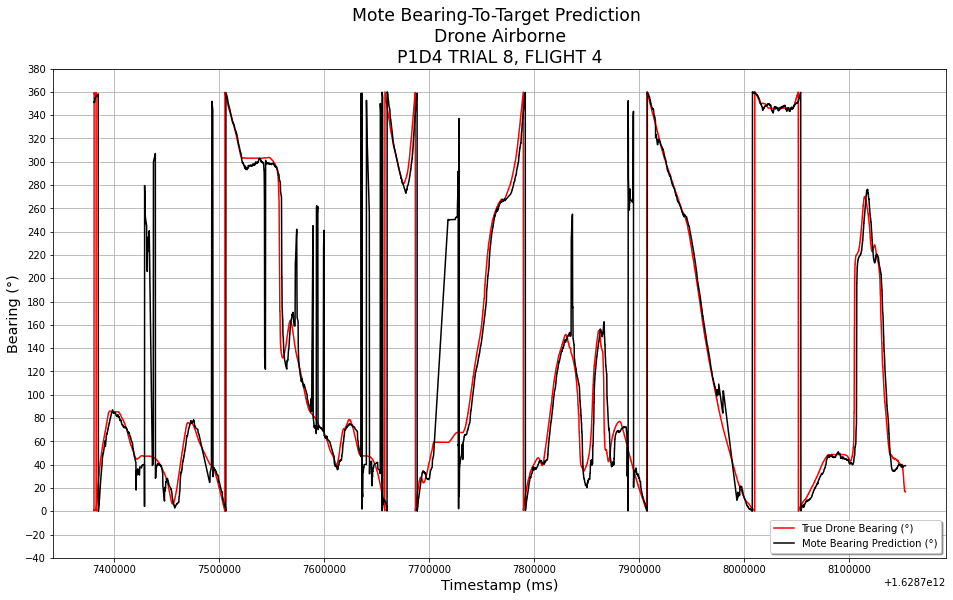

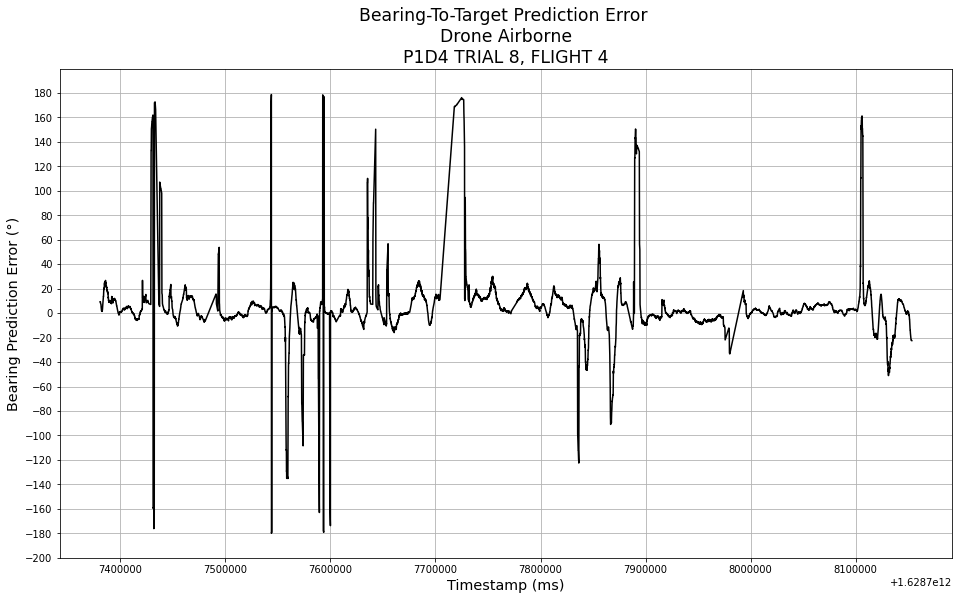

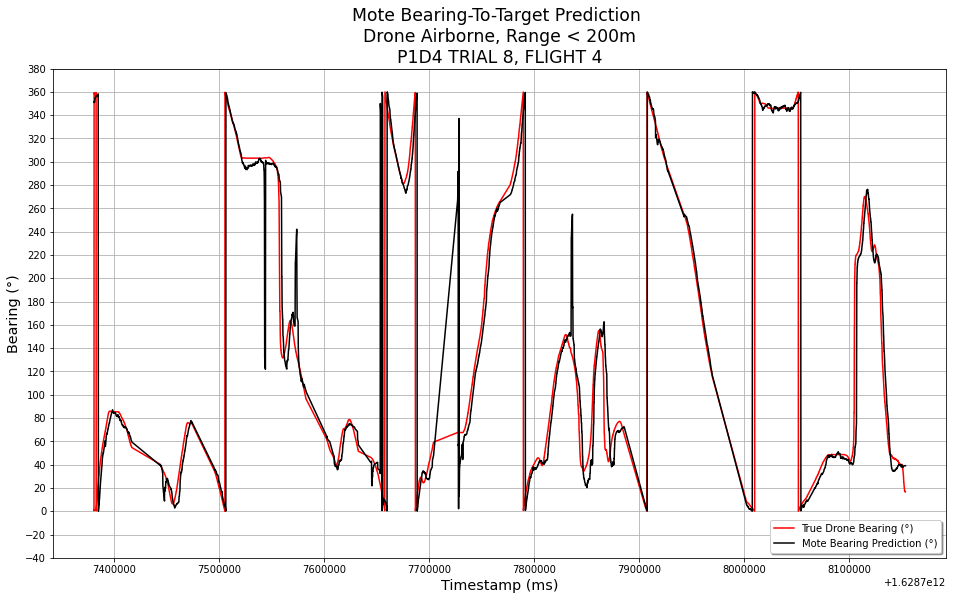

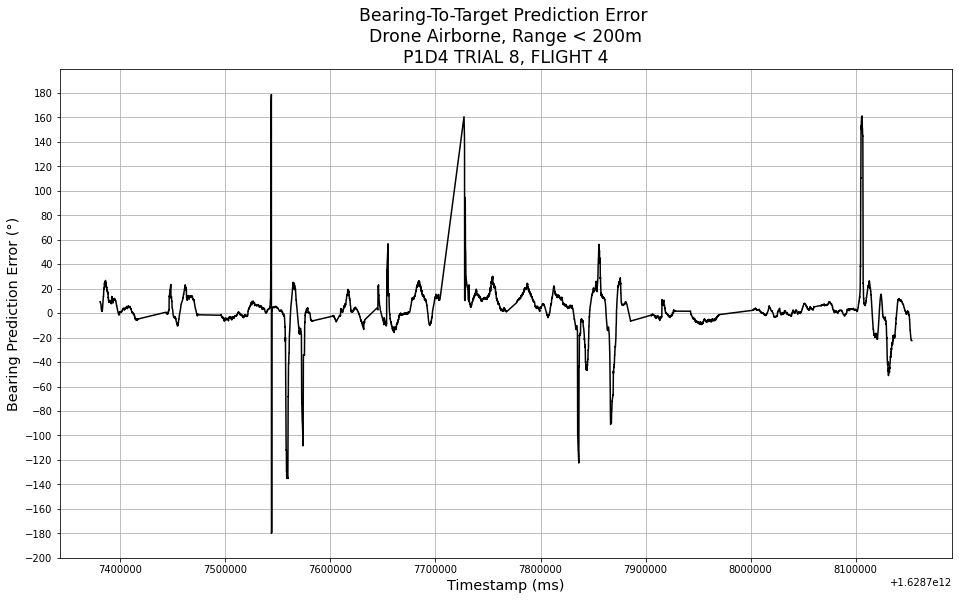

In [8]:
# Plot Mote Bearing-To-Target Prediction
title_str = 'Mote Bearing-To-Target Prediction \nDrone Airborne\n{}'.format(mission_str)
img_type = 'BTT_Pred'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotBearingPrediction(df = df1, title = title_str, path = fpath)

# Plot Bearing-To-Target Prediction Error
title_str = 'Bearing-To-Target Prediction Error \nDrone Airborne\n{}'.format(mission_str)
img_type = 'BTT_Err'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotBearingError(df = df1, title = title_str, path = fpath)

# Plot Mote Bearing-To-Target Prediction
title_str = 'Mote Bearing-To-Target Prediction \nDrone Airborne, Range < 200m\n{}'.format(mission_str)
img_type = 'BTT_Pred_Under_200m'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotBearingPrediction(df = df2, title = title_str, path = fpath)

# Plot Bearing-To-Target Prediction Error
title_str = 'Bearing-To-Target Prediction Error \nDrone Airborne, Range < 200m\n{}'.format(mission_str)
img_type = 'BTT_Err_Under_200m'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotBearingError(df = df2, title = title_str, path = fpath)

# Plot Range vs Prediction Error

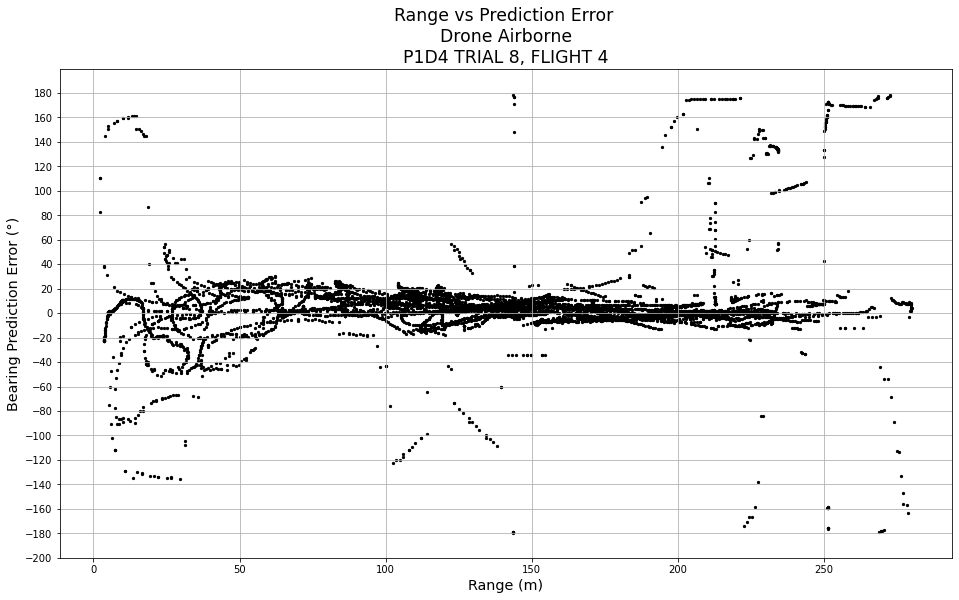

In [9]:
# Plot Plot Range vs Prediction Error
title_str = 'Range vs Prediction Error \nDrone Airborne\n{}'.format(mission_str)
img_type = 'RNG_Vs_Err'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotErrorVRange(df = df1, title = title_str, path = fpath)

# Plot Bearing Predicton Error Distribution

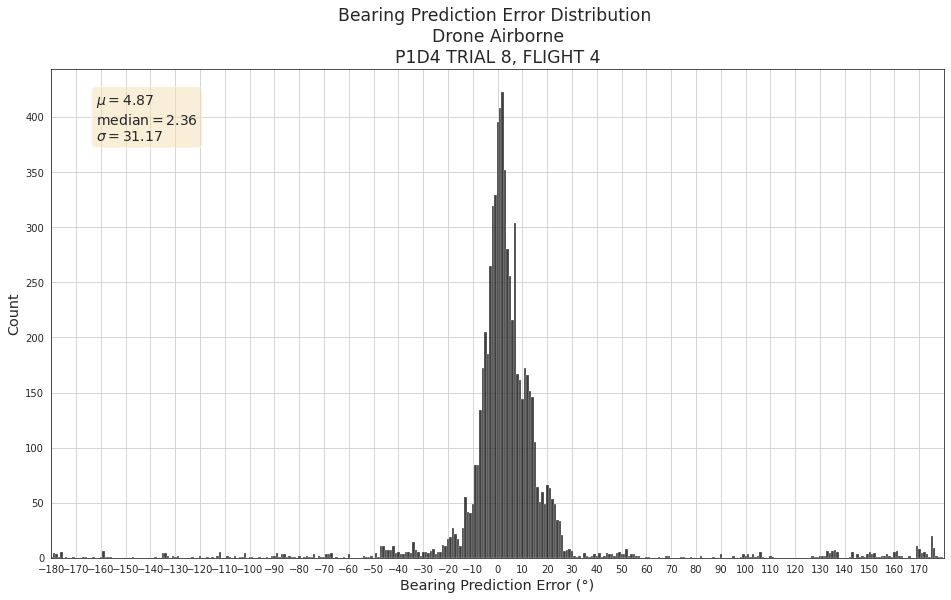

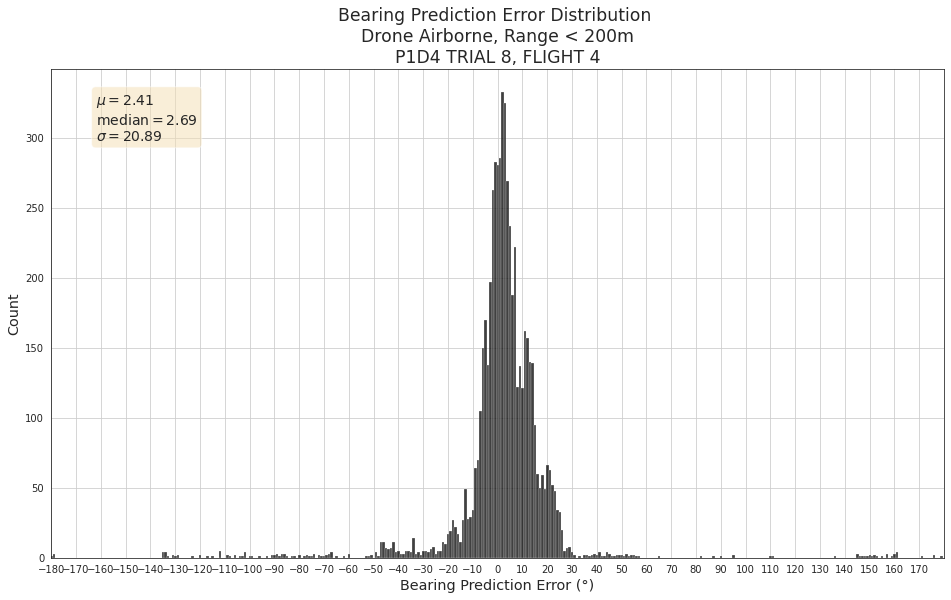

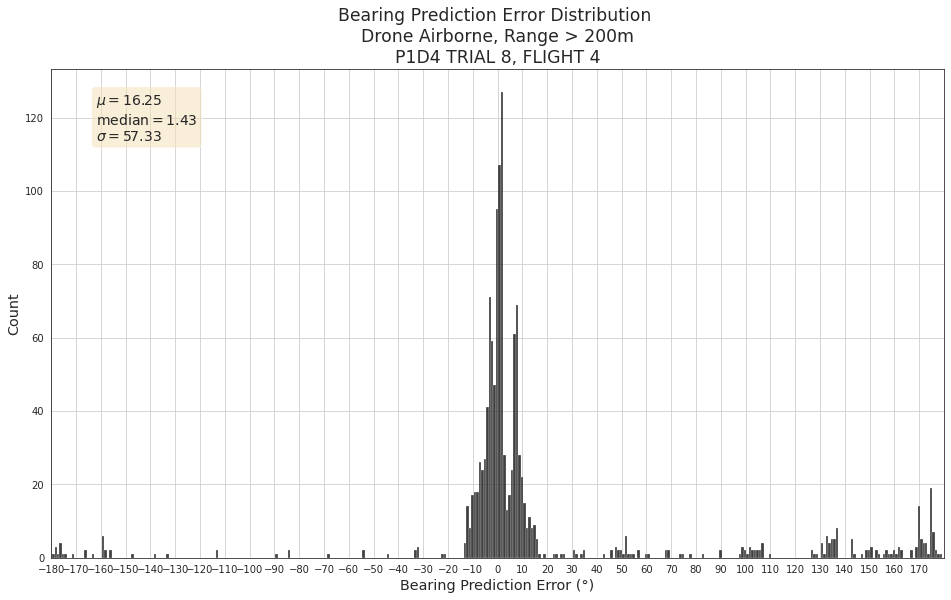

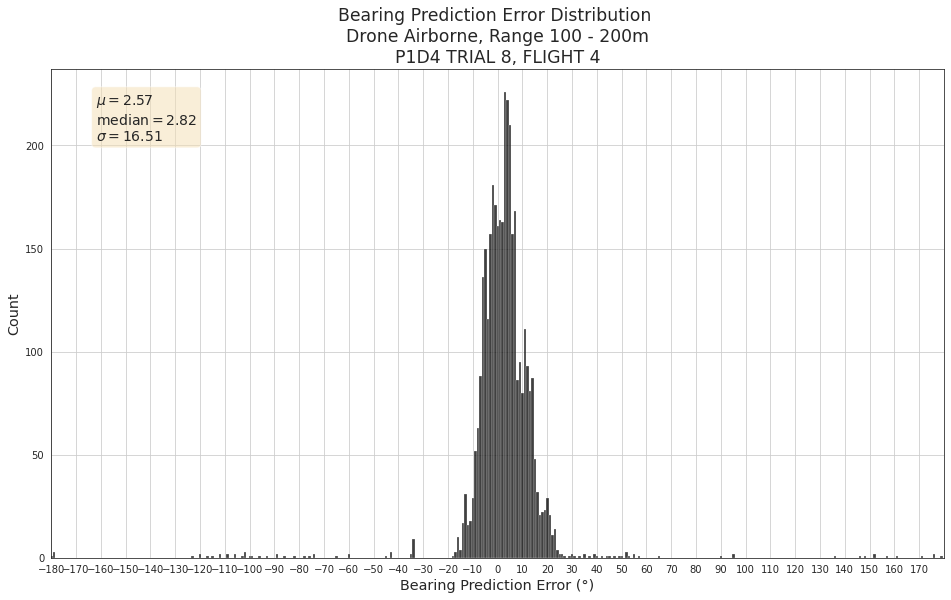

In [10]:
title_str = 'Bearing Prediction Error Distribution \nDrone Airborne\n{}'.format(mission_str)
img_type = 'Err_Dist'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotErrorDistribution(df = df1, title = title_str, path= fpath)

title_str = 'Bearing Prediction Error Distribution \nDrone Airborne, Range < 200m\n{}'.format(mission_str)
img_type = 'Err_Dist_under_200m'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotErrorDistribution(df = df2, title = title_str, path= fpath)

title_str = 'Bearing Prediction Error Distribution \nDrone Airborne, Range > 200m\n{}'.format(mission_str)
img_type = 'Err_Dist_over_200m'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotErrorDistribution(df = df3, title = title_str, path= fpath)

title_str = 'Bearing Prediction Error Distribution \nDrone Airborne, Range 100 - 200m\n{}'.format(mission_str)
img_type = 'Err_Dist_100_to_200m'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
PlotErrorDistribution(df = df4, title = title_str, path= fpath)

# Plot Mean Error and Standard Deviation by Range
Mean prediction error is equivalent to accuracy, Standard Deviation is equivalent to precision

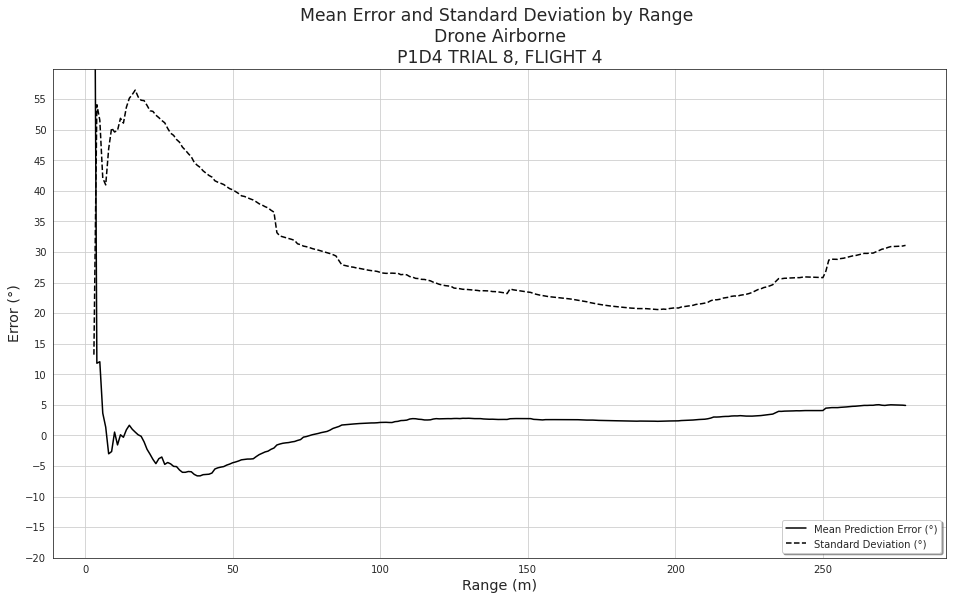

In [11]:
title_str = 'Mean Error and Standard Deviation by Range \nDrone Airborne\n{}'.format(mission_str)
img_type = 'Mean_Err_Vs_RNG'
fname = '{}_{}_{}'.format(round(time.time() * 1000), file_str, img_type)
fpath = os.path.join(img_path,fname)
AccuracyVsRange(df = df1, title=title_str, path = fpath)